**Author:** [Riccardo Guidotti](http://kdd.isti.cnr.it/people/riccardo-guidotti)  
**Python version:**  3.x

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

In [2]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve

# Data Preparation

In [3]:
df=pd.read_csv(r'../data/training.csv')

df['date'] =  pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
df['Time']= df['date'].apply(lambda x:x.time())
df['Date']= df['date'].apply(lambda x:x.date())
df['Time'] =  pd.to_timedelta(str(x) for x in df['Time'])
df['Date'] =  pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.drop('date', axis=1, inplace=True)
df['Holiday'] = df['Date'].apply(lambda x: 0 if x.weekday()<5 else 1 )
df['Hour']= df['Time'].apply(lambda x:'hour:'+str(x)[7:9])

#df.drop('HumidityRatio',inplace=True,axis=1)
df=df[df['Light']<1000] 

In [4]:
test=pd.read_csv(r'../data/test.csv')

test['date'] =  pd.to_datetime(test['date'], format='%Y-%m-%d %H:%M:%S')
test['Time']= test['date'].apply(lambda x:x.time())
test['Date']= test['date'].apply(lambda x:x.date())
test['Time'] =  pd.to_timedelta(str(x) for x in test['Time'])
test['Date'] =  pd.to_datetime(test['Date'], format='%Y-%m-%d')
test.drop('date', axis=1, inplace=True)
test['Holiday'] = test['Date'].apply(lambda x: 0 if x.weekday()<5 else 1 )
test['Hour']= test['Time'].apply(lambda x:'hour:'+str(x)[7:9])

#test.drop('HumidityRatio',inplace=True,axis=1)


# Data Partitioning

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Normalization

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [7]:
attributes = ['Temperature','CO2','Light','Humidity','HumidityRatio','Holiday'] 

X =df[attributes].values
y=df['Occupancy']
X_test=test[attributes].values
y_test=test['Occupancy']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=100, stratify=y)

scaler = StandardScaler()
scaler.fit(X)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# Perceptron

In [8]:
from sklearn.linear_model import Perceptron
clf = Perceptron(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9909208819714657
F1-score [0.99407031 0.98063624]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4747
           1       0.96      1.00      0.98      1421

    accuracy                           0.99      6168
   macro avg       0.98      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168



# Sklearn Multilayer Perceptron

In [9]:
from sklearn.neural_network import MLPClassifier

### Parameters

hidden_layer_sizes tuple, length = n_layers - 2, default=(100,)
The ith element represents the number of neurons in the ith hidden layer.

activation {'identity', 'logistic', 'tanh', 'relu'}, default='relu'
Activation function for the hidden layer.
* 'identity', no-op activation, useful to implement linear bottleneck, returns f(x) = x
* 'logistic', the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).
* 'tanh', the hyperbolic tan function, returns f(x) = tanh(x).
* 'relu', the rectified linear unit function, returns f(x) = max(0, x)

solver {'lbfgs', 'sgd', 'adam'}, default='adam'
The solver for weight optimization.
* 'lbfgs' is an optimizer in the family of quasi-Newton methods.
* 'sgd' refers to stochastic gradient descent.
* 'adam' refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba
The default solver 'adam' works pretty well on relatively large datasets (>= 1000 training samples) in terms of both training time and validation score. For small datasets, 'lbfgs' can converge faster and perform better.

alpha float, default=0.0001
L2 penalty (regularization term) parameter.

batch_size int, default='auto'
Size of minibatches for stochastic optimizers. If the solver is 'lbfgs', the classifier will not use minibatch. When set to “auto”, batch_size=min(200, n_samples)

learning_rate {'constant', 'invscaling', 'adaptive'}, default='constant'
Learning rate schedule for weight updates.
*'constant' is a constant learning rate given by 'learning_rate_init'.
*'invscaling' gradually decreases the learning rate at each time step 't' using an inverse scaling exponent of *'power_t'. effective_learning_rate = learning_rate_init / pow(t, power_t)
*'adaptive' keeps the learning rate constant to 'learning_rate_init' as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if 'early_stopping' is on, the current learning rate is divided by 5.
Only used when solver='sgd'.

learning_rate_init double, default=0.001
The initial learning rate used. It controls the step-size in updating the weights. Only used when solver='sgd' or 'adam'.

power_t double, default=0.5
The exponent for inverse scaling learning rate. It is used in updating effective learning rate when the learning_rate is set to 'invscaling'. Only used when solver='sgd'.

max_iter int, default=200
Maximum number of iterations. The solver iterates until convergence (determined by 'tol') or this number of iterations. For stochastic solvers ('sgd', 'adam'), note that this determines the number of epochs (how many times each data point will be used), not the number of gradient steps.

shuffle bool, default=True
Whether to shuffle samples in each iteration. Only used when solver='sgd' or 'adam'.

random_state int, RandomState instance or None, default=None
If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.

tol float, default=1e-4
Tolerance for the optimization. When the loss or score is not improving by at least tol for n_iter_no_change consecutive iterations, unless learning_rate is set to 'adaptive', convergence is considered to be reached and training stops.

verbose bool, default=False
Whether to print progress messages to stdout.

warm_start bool, default=False
When set to True, reuse the solution of the previous call to fit as initialization, otherwise, just erase the previous solution. See the Glossary.

momentum float, default=0.9
Momentum for gradient descent update. Should be between 0 and 1. Only used when solver='sgd'.

early_stopping bool, default=False
Whether to use early stopping to terminate training when validation score is not improving. If set to true, it will automatically set aside 10% of training data as validation and terminate training when validation score is not improving by at least tol for n_iter_no_change consecutive epochs. The split is stratified, except in a multilabel setting. Only effective when solver='sgd' or 'adam'

validation_fraction float, default=0.1
The proportion of training data to set aside as validation set for early stopping. Must be between 0 and 1. Only used if early_stopping is True

beta_1 float, default=0.9
Exponential decay rate for estimates of first moment vector in adam, should be in [0, 1). Only used when solver='adam'

beta_2 float, default=0.999
Exponential decay rate for estimates of second moment vector in adam, should be in [0, 1). Only used when solver='adam'

epsilon float, default=1e-8
Value for numerical stability in adam. Only used when solver='adam'

n_iter_no_change int, default=10
Maximum number of epochs to not meet tol improvement. Only effective when solver='sgd' or 'adam'


### Attributes
loss_ float
The current loss computed with the loss function.

coefs_ list, length n_layers - 1
The ith element in the list represents the weight matrix corresponding to layer i.

intercepts_ list, length n_layers - 1
The ith element in the list represents the bias vector corresponding to layer i + 1.

n_iter_ int,
The number of iterations the solver has ran.

n_layers_ int
Number of layers.

n_outputs_ int
Number of outputs.

out_activation_ string
Name of the output activation function.

In [15]:
#different learning rate schedules and momentum parameters
params = [{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'adam', 'learning_rate_init': 0.01}]

labels = ["constant learning-rate", "constant with momentum",
           "inv-scaling with nesterovs momentum", "adam"]

plot_args = [{'c': 'red', 'linestyle': '-'},
             {'c': 'green', 'linestyle': '-'},
             {'c': 'blue', 'linestyle': '--'},
             {'c': 'black', 'linestyle': '-.'}]

training: constant learning-rate
Training set score: 0.767241
Training set loss: 0.661294
training: constant with momentum
Training set score: 0.767241
Training set loss: 12.124717
training: inv-scaling with nesterovs momentum
Training set score: 0.767241
Training set loss: 41.811081
training: adam
Training set score: 0.990823
Training set loss: 0.046600


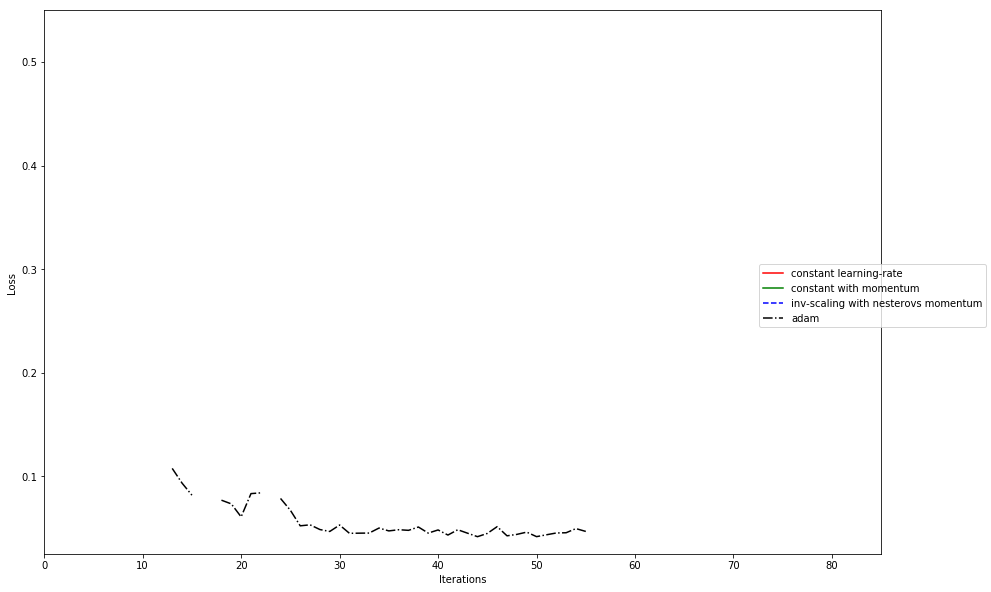

In [16]:
import warnings
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
        

fig, axes = plt.subplots(1, 1, figsize=(15, 10))      
  
for label, param, args in zip(labels, params,plot_args):
    print("training: %s" % label)
    mlp = MLPClassifier(random_state=0,
                           max_iter=200, **param)

        # some parameter combinations will not converge as can be seen on the
        # plots so they are ignored here
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning,
                                    module="sklearn")
        mlp.fit(X, y)

    axes.plot(mlp.loss_curve_, label=label, **args)
    print("Training set score: %f" % mlp.score(X, y))
    print("Training set loss: %f" % mlp.loss_)
    

        
        
        
axes.set_ylabel("Loss")
axes.set_xlabel("Iterations")
axes.set_xlim(0,85)
axes.set_ylim(0.025,0.55)
fig.legend(axes.get_lines(), labels,  loc=7)
plt.show()

0.021912353240478785
Accuracy 0.9917315175097277
F1-score [0.99460717 0.98228552]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4747
           1       0.97      1.00      0.98      1421

    accuracy                           0.99      6168
   macro avg       0.98      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168

0.02567476721116297


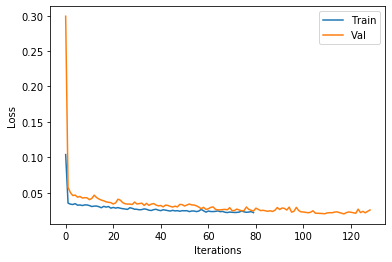

In [27]:
clf=None
#layer size = 2/3 inputSize + outputSzie
clf = MLPClassifier(random_state=0,solver= 'adam', learning_rate_init= 0.01, hidden_layer_sizes=(64,32,16))

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_score = clf.predict_log_proba(X_test)
print(clf.loss_)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
plt.plot(clf.loss_curve_, label="Train")
clf.fit(X_val, y_val)
print(clf.loss_)
plt.plot(clf.loss_curve_, label="Val")
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend()
plt.show()

In [ ]:
clf = MLPClassifier(random_state=0,solver= 'adam', learning_rate_init= 0.01, hidden_layer_sizes=(35,21,7))
scores = cross_val_score(clf, X_train, y_train, cv=20)
print('Accuracy: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf, X_train, y_train, cv=20, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

C:\Users\carlo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\carlo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\carlo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
clf = MLPClassifier(random_state=0,solver= 'sgd', learning_rate= 'constant', momentum= .9, hidden_layer_sizes=(35,21,7),
           nesterovs_momentum= True, learning_rate_init= 0.2)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_score = clf.predict_log_proba(X_test)
print(clf.loss_)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
plt.plot(clf.loss_curve_, label="Train")
clf.fit(X_val, y_val)
print(clf.loss_)
plt.plot(clf.loss_curve_, label="Val")
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend()
plt.show()

In [ ]:
plot_lift_curve(y_test, y_score)
plt.show()

0.041360055851465974
Accuracy 0.9907587548638133
F1-score [0.99396378 0.98029727]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4747
           1       0.96      1.00      0.98      1421

    accuracy                           0.99      6168
   macro avg       0.98      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168

0.04790895610832743


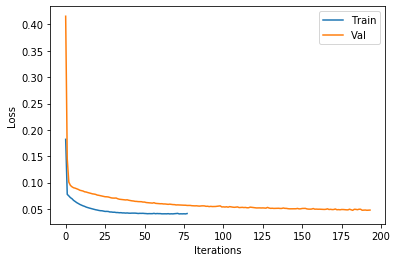

In [175]:
clf = MLPClassifier(hidden_layer_sizes=(128, 64, 32,), alpha=0.1, learning_rate='adaptive', 
                    activation='tanh', early_stopping=False, momentum=0.9, random_state=0)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_score = clf.predict_log_proba(X_test)
print(clf.loss_)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
plt.plot(clf.loss_curve_, label="Train")
clf.fit(X_val, y_val)
print(clf.loss_)
plt.plot(clf.loss_curve_, label="Val")
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend()
plt.show()

0.04020681094366478
Accuracy 0.9907587548638133
F1-score [0.99396506 0.98028364]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4747
           1       0.96      1.00      0.98      1421

    accuracy                           0.99      6168
   macro avg       0.98      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168

0.06732499385135472


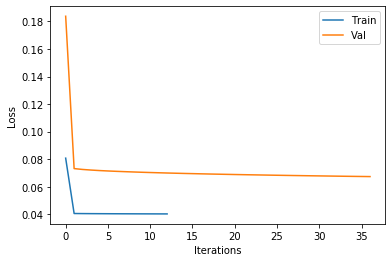

In [176]:
clf = MLPClassifier(solver= 'sgd', learning_rate= 'invscaling', momentum= 0,
            learning_rate_init= 0.8)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_score = clf.predict_log_proba(X_test)
print(clf.loss_)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
plt.plot(clf.loss_curve_, label="Train")
clf.fit(X_val, y_val)
print(clf.loss_)
plt.plot(clf.loss_curve_, label="Val")
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend()
plt.show()

# Keras Deep Neural Networks

In [81]:
y

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [10]:
from keras.models import Sequential
from keras.layers import Dense

Using Theano backend.


<ul>
<li>one <b>epoch</b> = one forward pass and one backward pass of all the training examples
<li><b>batch size</b> = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.
<li>number of <b>iterations</b> = number of passes, each pass using [batch size] number of examples. To be clear, one pass = one forward pass + one backward pass (we do not count the forward pass and backward pass as two different passes).
</ul><br>
Example: if you have 1000 training examples, and your batch size is 500, then it will take 2 iterations to complete 1 epoch.

chose a batch size : <ul>
<li><b>batch</b> mode: where the batch size is equal to the total dataset thus making the iteration and epoch values equivalent
<li><b>mini-batch</b> mode: where the batch size is greater than one but less than the total dataset size. Usually, a number that can be divided into the total dataset size.
<il><b>stochastic</b> mode: where the batch size is equal to one. Therefore the gradient and the neural network parameters are updated after each sample.

from keras.models import Sequential
from keras.layers import Dense

In [14]:
def build_model():
    
    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(35, input_dim=n_feature, activation='relu'))
    model.add(Dense(21, activation='relu'))
    model.add(Dense(7, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [15]:
model1 = build_model()

history1 = model1.fit(X_train, y_train, epochs=50, batch_size=10).history

KeyboardInterrupt: 

In [16]:
model2 = build_model()

history2 = model2.fit(X_train, y_train, epochs=50, batch_size=50).history

Epoch 1/50
11507/11507 [==============================] - 7s 594us/step - loss: 0.1692 - accuracy: 0.9339
Epoch 2/50
11507/11507 [==============================] - 6s 564us/step - loss: 0.0350 - accuracy: 0.9919
Epoch 3/50
11507/11507 [==============================] - 7s 599us/step - loss: 0.0339 - accuracy: 0.9917
Epoch 4/50
11507/11507 [==============================] - 2s 195us/step - loss: 0.0333 - accuracy: 0.99170s - loss: 0.0341 - accu
Epoch 5/50
11507/11507 [==============================] - 3s 279us/step - loss: 0.0324 - accuracy: 0.99200s - loss: 0.0317 - ac
Epoch 6/50
11507/11507 [==============================] - 4s 330us/step - loss: 0.0316 - accuracy: 0.9918
Epoch 7/50
11507/11507 [==============================] - 2s 176us/step - loss: 0.0313 - accuracy: 0.9919 - ETA: 0s -
Epoch 8/50
11507/11507 [==============================] - 5s 419us/step - loss: 0.0311 - accuracy: 0.9917
Epoch 9/50
11507/11507 [==============================] - 4s 372us/step - loss: 0.0303 - accur

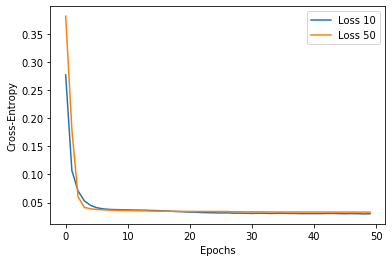

In [219]:
plt.plot(history1['loss'], label='Loss 10')
plt.plot(history2['loss'], label='Loss 50')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

In [102]:
test_loss_1, test_acc_1 = model1.evaluate(X_test, y_test)
test_loss_2, test_acc_2 = model2.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))

6168/6168 [==============================] - 0s 30us/step
Loss 0.025931, Accuracy 0.991732
Loss 0.027803, Accuracy 0.990759


In [103]:
y_pred = model2.predict(X_test).astype(int)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7696173800259404
F1-score [0.86981219 0.        ]
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      4747
           1       0.00      0.00      0.00      1421

    accuracy                           0.77      6168
   macro avg       0.38      0.50      0.43      6168
weighted avg       0.59      0.77      0.67      6168



C:\Users\carlo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from ann_visualizer.visualize import ann_viz;
#Build your model here
ann_viz(model1,view=True, filename="net.gv")

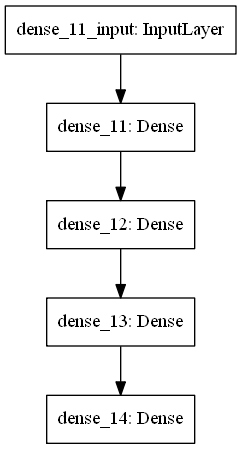

In [19]:
import pydot
from keras.utils import plot_model
plot_model(model2)

In [17]:
plot_model(model2)

NameError: name 'plot_model' is not defined

In [195]:
model3 = build_model()

history3 = model3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, batch_size=10).history

Train on 11512 samples, validate on 2879 samples
Epoch 1/1000
11512/11512 [==============================] - 3s 290us/step - loss: 0.1726 - accuracy: 0.9580 - val_loss: 0.0546 - val_accuracy: 0.9882
Epoch 2/1000
11512/11512 [==============================] - 4s 311us/step - loss: 0.0401 - accuracy: 0.9911 - val_loss: 0.0480 - val_accuracy: 0.9882
Epoch 3/1000
11512/11512 [==============================] - 4s 367us/step - loss: 0.0370 - accuracy: 0.9913 - val_loss: 0.0467 - val_accuracy: 0.9882
Epoch 4/1000
11512/11512 [==============================] - 3s 299us/step - loss: 0.0362 - accuracy: 0.9913 - val_loss: 0.0481 - val_accuracy: 0.9882
Epoch 5/1000
11512/11512 [==============================] - 3s 298us/step - loss: 0.0361 - accuracy: 0.9914 - val_loss: 0.0470 - val_accuracy: 0.9882
Epoch 6/1000
11512/11512 [==============================] - 4s 329us/step - loss: 0.0359 - accuracy: 0.9913 - val_loss: 0.0476 - val_accuracy: 0.9882
Epoch 7/1000
11512/11512 [=========================

6168/6168 [==============================] - 0s 30us/step
Loss 0.025931, Accuracy 0.991732
Loss 0.027803, Accuracy 0.990759
Loss 0.029171, Accuracy 0.991083


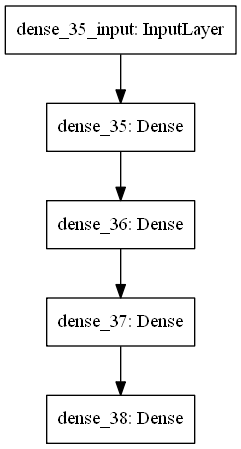

In [196]:
test_loss_3, test_acc_3 = model3.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))
print('Loss %f, Accuracy %f' % (test_loss_3, test_acc_3))
plot_model(model3)

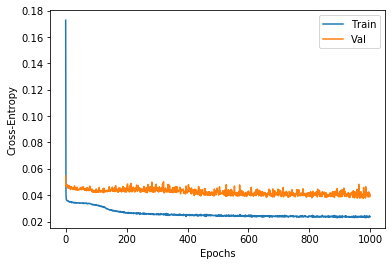

In [198]:
plt.plot(history3['loss'], label='Train')
plt.plot(history3['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

## Early Stopping

In [13]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

The most relevant arguments are:

* monitor: quantity to be monitored
* patience: number of epochs with no improvement after which training will be stopped

In [14]:
es = EarlyStopping(monitor='val_loss', patience=10)
mc = ModelCheckpoint('best_model_NOREG.h5', monitor='val_loss', save_best_only=True)

model4 = build_model()
history4 = model4.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, 
                      batch_size=10, callbacks=[es,mc]).history

Train on 11507 samples, validate on 2877 samples
Epoch 1/100
11507/11507 [==============================] - 3s 274us/step - loss: 0.1682 - accuracy: 0.9629 - val_loss: 0.0578 - val_accuracy: 0.9871
Epoch 2/100
11507/11507 [==============================] - 3s 223us/step - loss: 0.0388 - accuracy: 0.9917 - val_loss: 0.0531 - val_accuracy: 0.9871
Epoch 3/100
11507/11507 [==============================] - 2s 185us/step - loss: 0.0362 - accuracy: 0.9919 - val_loss: 0.0523 - val_accuracy: 0.9871
Epoch 4/100
11507/11507 [==============================] - 2s 212us/step - loss: 0.0354 - accuracy: 0.9919 - val_loss: 0.0484 - val_accuracy: 0.9871
Epoch 5/100
11507/11507 [==============================] - 3s 247us/step - loss: 0.0347 - accuracy: 0.9918 - val_loss: 0.0471 - val_accuracy: 0.9871
Epoch 6/100
11507/11507 [==============================] - 2s 189us/step - loss: 0.0343 - accuracy: 0.9919 - val_loss: 0.0479 - val_accuracy: 0.9871
Epoch 7/100
11507/11507 [==============================] 

In [15]:
test_loss_4, test_acc_4 = model4.evaluate(X_test, y_test)

#print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
#print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))
#print('Loss %f, Accuracy %f' % (test_loss_3, test_acc_3))
print('Loss %f, Accuracy %f' % (test_loss_4, test_acc_4))

6168/6168 [==============================] - 0s 60us/step
Loss 0.034048, Accuracy 0.990921


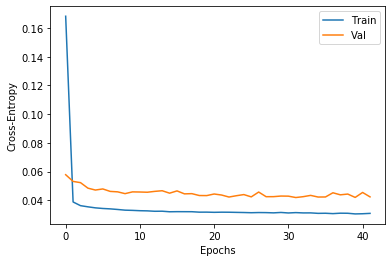

In [16]:
plt.plot(history4['loss'], label='Train')
plt.plot(history4['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

## L2 Regularization

In [20]:
from keras.regularizers import l2

def build_L2_model():
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    h_dim=1
    model.add(Dense(35, activation='relu', input_shape=(n_feature,), kernel_regularizer=l2(0.01)))
    model.add(Dense(21, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(7, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [22]:
mc = ModelCheckpoint('best_model_L2.h5', monitor='val_loss', save_best_only=True)

L2_model = build_L2_model()
h_L2 = L2_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, 
                    batch_size=10, callbacks=[es,mc]).history

NameError: name 'ModelCheckpoint' is not defined

In [59]:
from keras.layers import Dropout

def build_DROPOUT_model():
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    h_dim=100
    model.add(Dense(h_dim, activation='relu', input_shape=(n_feature,)))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [60]:
mc = ModelCheckpoint('best_model_DROPOUT.h5', monitor='val_loss', save_best_only=True)

DROPOUT_model = build_DROPOUT_model()
h_DROPOUT = DROPOUT_model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                              epochs=100, batch_size=10, callbacks=[es,mc]).history

KeyboardInterrupt: 

In [61]:
# laod best models and test them
from keras.models import load_model

best_NOREG_model = load_model('best_model_NOREG.h5')
best_L2_model = load_model('best_model_L2.h5')
best_DROPOUT_model = load_model('best_model_DROPOUT.h5')

loss_NOREG, acc_NOREG = best_NOREG_model.evaluate(X_test, y_test)
loss_L2, acc_L2 = best_L2_model.evaluate(X_test, y_test)
loss_DROPOUT, acc_DROPOUT = best_DROPOUT_model.evaluate(X_test, y_test)

6168/6168 [==============================] - 5s 787us/step


In [62]:
print('Loss %f, Accuracy %f' % (loss_NOREG, acc_NOREG))
print('Loss %f, Accuracy %f' % (loss_L2, acc_L2))
print('Loss %f, Accuracy %f' % (loss_DROPOUT, acc_DROPOUT))

Loss 0.034552, Accuracy 0.990759
Loss 0.169186, Accuracy 0.971628
Loss 0.144954, Accuracy 0.000000


## Hyper-Parameter Tuning

In [63]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

In [64]:
def build_model(n_layers=2, h_dim=5, activation='relu', optimizer='adam'):
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    
    model.add(Dense(h_dim, activation=activation, input_shape=(n_feature,)))
    for i in range(n_layers-1):
        model.add(Dense(h_dim, activation=activation))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [65]:
n_layers = [1, 2, 3]
h_dim = [7, 15, 21]
activation = ['relu', 'tanh']
optimizer = ['adagrad', 'adam']
params = dict(optimizer=optimizer, n_layers=n_layers, h_dim=h_dim, activation=activation)

In [66]:
X.shape

(14384, 6)

In [67]:
model = KerasRegressor(build_fn=build_model)

rnd = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=5, cv=3)
rnd_result = rnd.fit(X, y, epochs=100, batch_size=10, verbose=0)

4794/4794 [==============================] - 9s 2ms/step


In [68]:
print("Best: %f using %s" % (-rnd_result.best_score_, rnd_result.best_params_))
means = rnd_result.cv_results_['mean_test_score']
stds = rnd_result.cv_results_['std_test_score']
params = rnd_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (-mean, stdev, param))

Best: 0.282419 using {'optimizer': 'adagrad', 'n_layers': 3, 'h_dim': 7, 'activation': 'tanh'}
5.284746 (5.092191) with: {'optimizer': 'adam', 'n_layers': 1, 'h_dim': 7, 'activation': 'tanh'}
6.511088 (3.974887) with: {'optimizer': 'adam', 'n_layers': 2, 'h_dim': 15, 'activation': 'relu'}
1.364287 (1.759934) with: {'optimizer': 'adam', 'n_layers': 2, 'h_dim': 15, 'activation': 'tanh'}
1.539162 (1.640737) with: {'optimizer': 'adagrad', 'n_layers': 2, 'h_dim': 15, 'activation': 'tanh'}
0.282419 (0.174601) with: {'optimizer': 'adagrad', 'n_layers': 3, 'h_dim': 7, 'activation': 'tanh'}


In [69]:
clf = rnd_result.best_estimator_.model

loss, acc = clf.evaluate(X_test, y_test)
print('Loss %f, Accuracy %f' % (loss, acc))

6168/6168 [==============================] - 16s 3ms/step
Loss 5.686455, Accuracy 0.332523


In [70]:
historyBest = clf.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=10).history

Train on 11507 samples, validate on 2877 samples
Epoch 1/100
11507/11507 [==============================] - 4s 373us/step - loss: 0.2106 - accuracy: 0.6246 - val_loss: 0.1220 - val_accuracy: 0.5850
Epoch 2/100
11507/11507 [==============================] - 4s 345us/step - loss: 0.0843 - accuracy: 0.5667 - val_loss: 0.0961 - val_accuracy: 0.5728
Epoch 3/100
11507/11507 [==============================] - 4s 389us/step - loss: 0.0834 - accuracy: 0.5511 - val_loss: 0.1269 - val_accuracy: 0.5280
Epoch 4/100
11507/11507 [==============================] - 4s 368us/step - loss: 0.0817 - accuracy: 0.5017 - val_loss: 0.0890 - val_accuracy: 0.4793
Epoch 5/100
 4660/11507 [===========>..................] - ETA: 2s - loss: 0.0774 - accuracy: 0.4524 ETA: 3s - loss: 0

KeyboardInterrupt: 

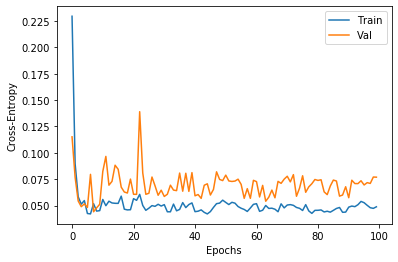

In [41]:
plt.plot(historyBest['loss'], label='Train')
plt.plot(historyBest['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()